In [ ]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!pwd
!kaggle datasets download -d asifhasan24/raw-dataset
!unzip /content/raw-dataset.zip
!pip install -U tensorflow-addons

/content
100% 4.95G/4.95G [00:55<00:00, 62.3MB/s]
100% 4.95G/4.95G [00:55<00:00, 95.4MB/s]
Archive:  /content/raw-dataset.zip
  inflating: Raw Dataset/Cescospora Leaf Spot/Cescospora_leaf_spot  (1).jpg  
  inflating: Raw Dataset/Cescospora Leaf Spot/Cescospora_leaf_spot  (10).jpg  
  inflating: Raw Dataset/Cescospora Leaf Spot/Cescospora_leaf_spot  (100).jpg  
  inflating: Raw Dataset/Cescospora Leaf Spot/Cescospora_leaf_spot  (101).jpg  
  inflating: Raw Dataset/Cescospora Leaf Spot/Cescospora_leaf_spot  (102).jpg  
  inflating: Raw Dataset/Cescospora Leaf Spot/Cescospora_leaf_spot  (103).jpg  
  inflating: Raw Dataset/Cescospora Leaf Spot/Cescospora_leaf_spot  (104).jpg  
  inflating: Raw Dataset/Cescospora Leaf Spot/Cescospora_leaf_spot  (105).jpg  
  inflating: Raw Dataset/Cescospora Leaf Spot/Cescospora_leaf_spot  (106).jpg  
  inflating: Raw Dataset/Cescospora Leaf Spot/Cescospora_leaf_spot  (107).jpg  
  inflating: Raw Dataset/Cescospora Leaf Spot/Cescospora_leaf_spot  (108).jpg

In [ ]:
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalMaxPooling2D, Dropout, Input
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy
import os
from glob import glob
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import gc
from skimage import exposure
from scipy.ndimage import gaussian_filter

# Set data directory
train_data_directory = "/content/Raw Dataset"

# Define classes
classes = ["Cescospora Leaf Spot", "Golden Mosaic", "Healthy Leaf"]
num_classes = 3
img_size = 224

# Load training data with unsharp masking
def load_images_from_directory(directory, random_state=None):
    images = []
    labels = []

    for class_index, class_name in enumerate(classes):
        class_path = os.path.join(directory, class_name)
        image_files = glob(os.path.join(class_path, "*.jpg"))
        for image_file in image_files:
            image = cv2.imread(image_file)

            image = cv2.resize(image, (img_size, img_size))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            images.append(image)
            labels.append(class_index)

    images = np.array(images)
    labels = np.array(labels)

    # Use train_test_split to shuffle and split the data
    x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=random_state, stratify=labels)

    return x_train, y_train, x_test, y_test  # Return both training and test sets



# Load training data
x_train, y_train, x_test, y_test = load_images_from_directory(train_data_directory, random_state=42)



# Print shapes
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")



x_train shape: (736, 224, 224, 3) - y_train shape: (736,)
x_test shape: (184, 224, 224, 3) - y_test shape: (184,)


In [ ]:
import os
from glob import glob
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import math

# Set your data and parameters
input_shape = (224, 224, 3)
learning_rate = 0.0001
weight_decay = 0.0001
batch_size = 16
num_epochs = 200
image_size = 224
patch_size = 6
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 2
transformer_units = [projection_dim * 2, projection_dim]
transformer_layers = 8
mlp_head_units = [2048, 1024]
validation_split = 0.1
label_smoothing = 0.1

# Data Augmentation
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)

# Patching and Encoding layers
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

# MultiHeadAttention with custom modifications
class MultiHeadAttention(tf.keras.layers.MultiHeadAttention):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.tau = tf.Variable(math.sqrt(float(self._key_dim)), trainable=True)

    def _compute_attention(self, query, key, value, attention_mask=None, training=None):
        query = tf.multiply(query, 1.0 / self.tau)
        attention_scores = tf.einsum(self._dot_product_equation, key, query)
        attention_scores = self._masked_softmax(attention_scores, attention_mask)
        attention_scores_dropout = self._dropout_layer(
            attention_scores, training=training
        )
        attention_output = tf.einsum(
            self._combine_equation, attention_scores_dropout, value
        )
        return attention_output, attention_scores

# MLP layer function
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# Create the ViT model
inputs = layers.Input(shape=input_shape)
augmented = data_augmentation(inputs)

patches = Patches(patch_size)(augmented)
encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

for _ in range(transformer_layers):
    x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    attention_output = MultiHeadAttention(
        num_heads=num_heads, key_dim=projection_dim, dropout=0.1
    )(x1, x1)
    x2 = layers.Add()([attention_output, encoded_patches])
    x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
    x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
    encoded_patches = layers.Add()([x3, x2])

representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
representation = layers.Flatten()(representation)
representation = layers.Dropout(0.5)(representation)
features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
logits = layers.Dense(num_classes)(features)

model = keras.Model(inputs=inputs, outputs=logits)

# Compile and train the model
optimizer = tfa.optimizers.AdamW(
    learning_rate=learning_rate, weight_decay=weight_decay
)

model.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)


# Training the model
checkpoint_filepath = "/tmp/checkpoint"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
)

history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=validation_split,
    callbacks=[checkpoint_callback],
)

# Loading the best weights
model.load_weights(checkpoint_filepath)

# Evaluate the model on the test set
test_loss, test_accuracy, test_top_5_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Top 5 Accuracy: {test_top_5_accuracy}")

# Save the trained model
# model.save("vit_classifier.h5")


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Epoch 1/200
42/42 [==============================] - 69s 958ms/step - loss: 11.1616 - accuracy: 0.4139 - top-5-accuracy: 1.0000 - val_loss: 1.6031 - val_accuracy: 0.5676 - val_top-5-accuracy: 1.0000
Epoch 2/200
42/42 [==============================] - 32s 777ms/step - loss: 7.2385 - accuracy: 0.4894 - top-5-accuracy: 1.0000 - val_loss: 1.9651 - val_accuracy: 0.6081 - val_top-5-accuracy: 1.0000
Epoch 3/200
42/42 [==============================] - 36s 866ms/step - loss: 4.4663 - accuracy: 0.5151 - top-5-accuracy: 1.0000 - val_loss: 1.1114 - val_accuracy: 0.6622 - val_top-5-accuracy: 1.0000
Epoch 4/200
42/42 [==============================] - 22s 512ms/step - loss: 2.1551 - accuracy: 0.5619 - top-5-accuracy: 1.0000 - val_loss: 0.9845 - val_accuracy: 0.6622 - val_top-5-accuracy: 1.0000
Epoch 5/200
42/42 [==============================] - 38s 908ms/step - loss: 1.2218 - accuracy: 0.5725 - top-5-accuracy: 1.0000 - val_loss: 0.6750 - val_accuracy: 0.7027 - val_top-5-accuracy: 1.0000
Epoch 6/2

6/6 [==============================] - 3s 262ms/step


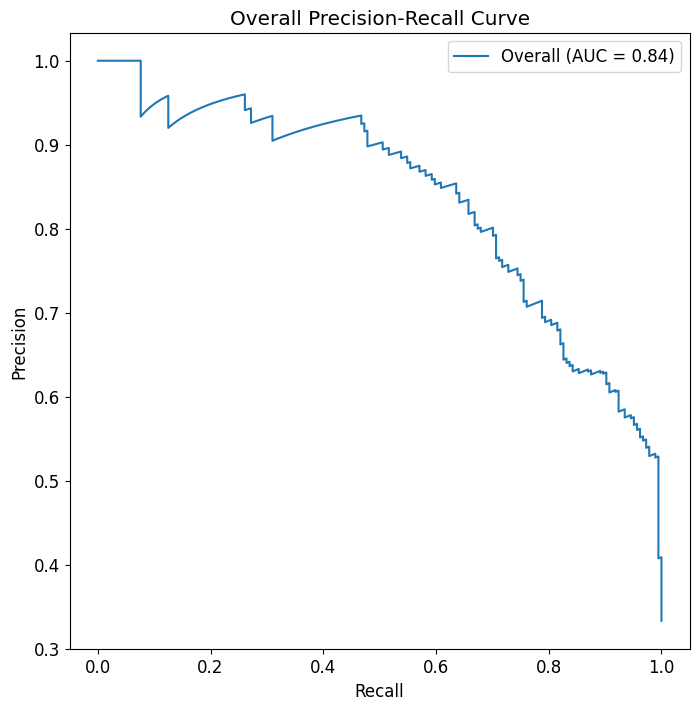

In [ ]:
from keras.utils import to_categorical
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Convert labels to one-hot encoding
y_test_one_hot = to_categorical(y_test, num_classes=num_classes)

# Get predicted probabilities for each class
y_pred_prob = model.predict(x_test)

# Flatten the arrays
y_test_flat = y_test_one_hot.ravel()
y_pred_prob_flat = y_pred_prob.ravel()

# Compute precision-recall curve
precision, recall, _ = precision_recall_curve(y_test_flat, y_pred_prob_flat)
pr_auc = auc(recall, precision)

# Plot the overall precision-recall curve
plt.figure(figsize=(8, 8))
plt.plot(recall, precision, label=f'Overall (AUC = {pr_auc:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Overall Precision-Recall Curve')
plt.legend()
plt.show()


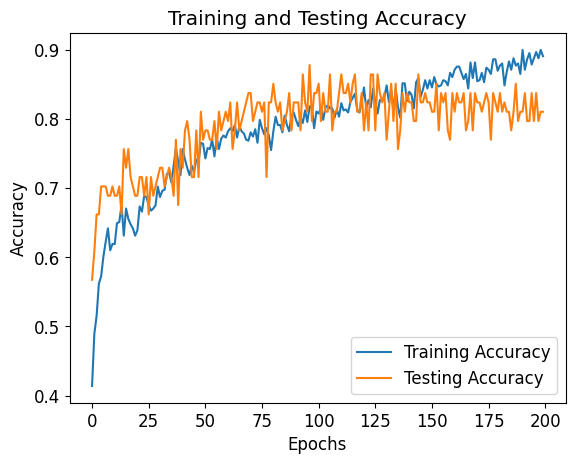

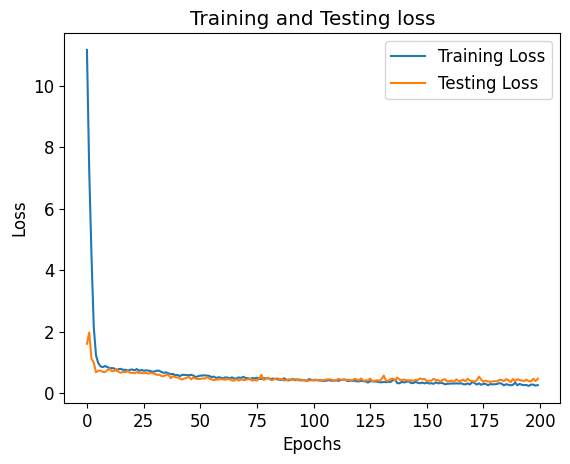

In [ ]:
# Plot the accuracy curves
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
# Plot training accuracy and validation/test accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Testing Accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
# Plot the accuracy curves
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
# Plot training accuracy and validation/test accuracy
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Testing Loss')
plt.title('Training and Testing loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

6/6 [==============================] - 3s 265ms/step


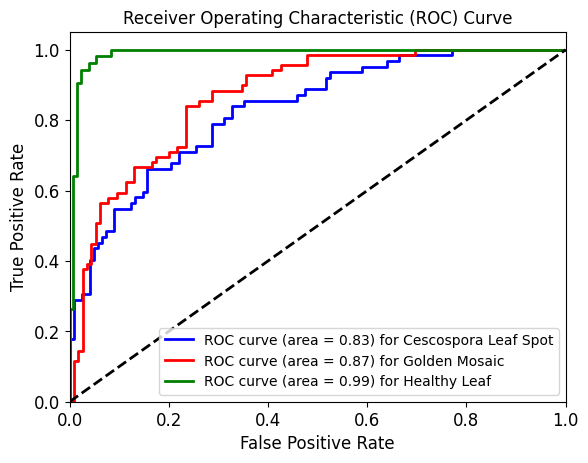

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from scipy import interp

# Get the predicted probabilities for each class
y_pred_proba = model.predict([x_test])

# Compute the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for class_index in range(num_classes):
    y_true_binary = y_test == class_index
    fpr[class_index], tpr[class_index], _ = roc_curve(y_true_binary, y_pred_proba[:, class_index])
    roc_auc[class_index] = auc(fpr[class_index], tpr[class_index])

# Plot the ROC curve for each class
plt.figure()
colors = ['blue', 'red', 'green', 'orange', 'purple']  # Adjust the colors as needed
for class_index in range(num_classes):
    plt.plot(fpr[class_index], tpr[class_index], color=colors[class_index], lw=2,
             label='ROC curve (area = %0.2f) for %s' % (roc_auc[class_index], classes[class_index]))
plt.rcParams.update({'font.size': 10})
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


6/6 [==============================] - 2s 267ms/step


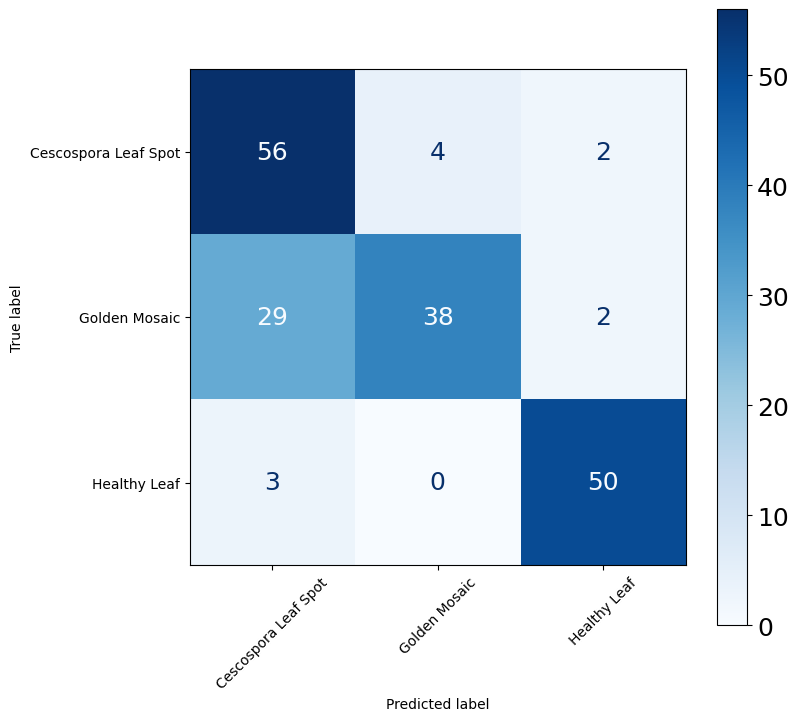

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
# model = load_model("/content/trained_model.h5")
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Make predictions on the test set
predictions = np.argmax(model.predict([x_test]), axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_test, predictions)
#"Col_Ade", "Col_Ben","lun_Ben","lun_Ade","lun_Squ"
# Plot the confusion matrix
# labels =["Field Cricket", "Jute Stem Weevil", "Spilosoma Obliqua", "Yellow Mite"]
labels = ["Cescospora Leaf Spot", "Golden Mosaic", "Healthy Leaf"] # The class labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(8, 8))
plt.rcParams.update({'font.size': 18})  # Adjust the figure size if needed
disp.plot(cmap=plt.cm.Blues, ax=ax)
# plt.title("Confusion Matrix")
plt.xticks(rotation=45)  # Rotate the x-axis tick labels by 45 degrees
plt.savefig('confusion_matrix6.png', format='png', bbox_inches='tight')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Get the predicted class labels for the test set
predictions = model.predict([x_test])
predicted_labels = np.argmax(predictions, axis=1)

# Calculate the accuracy, precision, recall, and F1-score for each class
class_accuracies = []
class_precisions = []
class_recalls = []
class_f1_scores = []
for class_index in range(num_classes):
    y_true_binary = y_test == class_index
    predictions_binary = predicted_labels == class_index
    class_accuracy = accuracy_score(y_true_binary, predictions_binary)
    class_precision = precision_score(y_true_binary, predictions_binary)
    class_recall = recall_score(y_true_binary, predictions_binary)
    class_f1_score = f1_score(y_true_binary, predictions_binary)
    class_accuracies.append(class_accuracy)
    class_precisions.append(class_precision)
    class_recalls.append(class_recall)
    class_f1_scores.append(class_f1_score)

# Print the accuracy, precision, recall, and F1-score for each class
for class_index in range(num_classes):
    print(f"Class {class_index} Accuracy: {class_accuracies[class_index]:.4f}")
    print(f"Class {class_index} Precision: {class_precisions[class_index]:.4f}")
    print(f"Class {class_index} Recall: {class_recalls[class_index]:.4f}")
    print(f"Class {class_index} F1-score: {class_f1_scores[class_index]:.4f}")


6/6 [==============================] - 2s 267ms/step
Class 0 Accuracy: 0.7935
Class 0 Precision: 0.6364
Class 0 Recall: 0.9032
Class 0 F1-score: 0.7467
Class 1 Accuracy: 0.8098
Class 1 Precision: 0.9048
Class 1 Recall: 0.5507
Class 1 F1-score: 0.6847
Class 2 Accuracy: 0.9620
Class 2 Precision: 0.9259
Class 2 Recall: 0.9434
Class 2 F1-score: 0.9346
